In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

import copy

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('data.csv')
columns = list(df.columns)
df.head()

,index,totalCarNumber,numberOfTrips,median_overhead,q1_overhead,q3_overhead,p9_overhead
0,0,450,956,1.705182,1.359793,2.123084,2.718418
1,1,450,1467,1.714930,1.394722,2.121029,2.545487
2,2,450,1337,1.739680,1.409681,2.158247,2.641959
3,3,450,1373,1.714649,1.382665,2.124727,2.629434
4,4,450,1421,1.724623,1.359472,2.116151,2.623198


In [3]:
df_before =df.iloc[:144, :]


indexes = np.array_split(df_before.index,8, axis=0)
for i,index in enumerate(indexes):
    df_before.loc[index,'group'] = i
    
df_before['c'] = df_before['group'].diff()
df_filtered = df_before[df_before['c'] != 0]

index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
# print(len(index_list))
# print('\n')
# print(index_list)

l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
list_of_dfs_before = [df_before.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

# len(list_of_dfs)



/home/marta/env/lib/python3.6/site-packages/pandas-1.0.3-py3.6-linux-x86_64.egg/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/marta/env/lib/python3.6/site-packages/pandas-1.0.3-py3.6-linux-x86_64.egg/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [3]:
traindf = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead']].copy()
traindf = traindf.to_numpy()
traindf_list = np.split(traindf, 18)

traindf_before =  df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead']].copy()
traindf_before =traindf_before.iloc[:144, :]
traindf_before = traindf_before.to_numpy()
traindf_before_list = np.split(traindf_before, 24)


# data_to_plot = df.iloc[::6, :]
# # data_to_plot.head()
# data_to_plot = data_to_plot.to_numpy()
data_to_plot = df.to_numpy()

data_to_plot_before = df.iloc[:144, :]
data_to_plot_before = data_to_plot_before.to_numpy()

In [4]:
def plot_silhouette_scores(model, test_data, n_clusters_min, n_clusters_max):
    """ Plot silhouette scores and return the best number of clusters"""

    if len(model.subcluster_labels_) >= 2:

        silhouette_scores = []

        clusters_range = range(n_clusters_min, n_clusters_max+1)
        results_dict = []
        # print(clusters_range)
        for number in clusters_range:
            # make a copy of the model so as not to mess up the 'correct' model
            model_cpy = copy.deepcopy(model)
            model_cpy.set_params(n_clusters=number)

            model_cpy.partial_fit()
            labels = model_cpy.predict(test_data)
            # print(labels)
            try: 
                s = metrics.silhouette_score(test_data, labels, metric='euclidean')
                silhouette_scores.append(s)
                results_dict.append((number, s))
            except ValueError:
                pass

        silhouette_range = [i[0] for i in results_dict]  
        max_score = max(silhouette_scores)
        for i in results_dict:
            if i[1] == max_score:
                return int(i[0])
    else:
        return n_clusters_min

In [5]:
def combine_dfs(df_list):
    return pd.concat(df_list)

In [6]:
def outliers_removal(df):
    data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
#     data_split_modified_z = data_split_modified_z.iloc[:144, :]
    data_split_modified_z = data_split_modified_z.to_numpy()
    data_split_modified_z_12 = np.split(data_split_modified_z, 1)
    indexes = [] 

    for d in range(len(data_split_modified_z_12)):
        ind = []
        k = len(data_split_modified_z_12[d])
        for i in [0, 1, 2, 3]:
            ys = data_split_modified_z_12[d][:,i] 
            median_y = np.median(ys)
            median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    #         print(median_absolute_deviation_y)
            for y in range(len(data_split_modified_z_12[d])):
                modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
    #             z_score = (data_split[d][y, i]  - mean_ys) / std_ys
                if np.abs(modified_z_score) > 3.5:
                    ind.append(y)


        data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)
        print('Outliers detected: ' + str((k - len(data_split_modified_z_12[d]))))

    data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)
    return data_split_modified_z_12

In [8]:
data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
data_split_modified_z = data_split_modified_z.iloc[:144, :]
data_split_modified_z = data_split_modified_z.to_numpy()

""" SIZE 12 """
data_split_modified_z_12 = np.split(data_split_modified_z, 8)
indexes = [] 

for d in range(len(data_split_modified_z_12)):
    ind = []
    k = len(data_split_modified_z_12[d])
    for i in [0, 1, 2, 3]:
        ys = data_split_modified_z_12[d][:,i] 
        median_y = np.median(ys)
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
#         print(median_absolute_deviation_y)
        for y in range(len(data_split_modified_z_12[d])):
            modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
#             z_score = (data_split[d][y, i]  - mean_ys) / std_ys
            if np.abs(modified_z_score) > 3.5:
                ind.append(y)


    data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)
#     print('Outliers detected: ' + str((k - len(data_split_modified_z_12[d]))))

# data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)

In [9]:
data_split_modified_z_12_list = np.split(data_split_modified_z_12, 2)

In [10]:
model_001 = Birch(n_clusters=None, threshold=0.01)

for i in data_split_modified_z_12_list:
    model_001.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)
print('0.01')
n = plot_silhouette_scores(model_001, data_split_modified_z_12[:, :-2], 2, 6)

model_001.set_params(n_clusters = n)
model_001.partial_fit()
    
labels_001 = model_001.predict(data_split_modified_z_12[:, :-2])

##########################################################
model_005 = Birch(n_clusters=None, threshold=0.05)

for i in data_split_modified_z_12_list:
    model_005.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)
print('0.05')
n = plot_silhouette_scores(model_005, data_split_modified_z_12[:, :-2], 2, 6)

model_005.set_params(n_clusters = n)
model_005.partial_fit()
    
labels_005 = model_005.predict(data_split_modified_z_12[:, :-2])

##########################################################

model_01= Birch(n_clusters=None, threshold=0.1)

for i in data_split_modified_z_12_list:
    model_01.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)
print('0.1')
n = plot_silhouette_scores(model_01, data_split_modified_z_12[:, :-2], 2, 6)

model_01.set_params(n_clusters = n)
model_01.partial_fit()
    
labels_01 = model_01.predict(data_split_modified_z_12[:, :-2])
##########################################################

model_02 = Birch(n_clusters=None, threshold=0.2)

for i in data_split_modified_z_12_list:
#     numpy_array = outliers_removal(i)
    model_02.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)
print('0.2')
n = plot_silhouette_scores(model_02, data_split_modified_z_12[:, :-2], 2, 6)

model_02.set_params(n_clusters = n)
model_02.partial_fit()
    
labels_02 = model_02.predict(data_split_modified_z_12[:, :-2])

##########################################################

model_03 = Birch(n_clusters=None, threshold=0.3)

for i in data_split_modified_z_12_list:
    model_03.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)
print('0.3')

n = plot_silhouette_scores(model_03, data_split_modified_z_12[:, :-2], 2, 6)

model_03.set_params(n_clusters = n)
model_03.partial_fit()
    
labels_03 = model_03.predict(data_split_modified_z_12[:, :-2])



##############################################################

model = Birch(n_clusters=None, threshold=0.5)

for i in data_split_modified_z_12_list:
    model.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)
print('0.5')

n = plot_silhouette_scores(model, data_split_modified_z_12[:, :-2], 2, 6)

model.set_params(n_clusters = n)
model.partial_fit()
    
labels = model.predict(data_split_modified_z_12[:, :-2])

0.01
[(2, 0.6828536656861623), (3, 0.5856980436981691), (4, 0.603594984278065), (5, 0.5159251848968918), (6, 0.47147646523309233)]
The highest silhouette scores(0.6828536656861623) is for 2 clusers


0.05
[(2, 0.6828536656861623), (3, 0.5856980436981691), (4, 0.603594984278065), (5, 0.48215897682580827), (6, 0.4550514528251643)]
The highest silhouette scores(0.6828536656861623) is for 2 clusers


0.1
[(2, 0.6828536656861623), (3, 0.6556031588628115), (4, 0.603594984278065), (5, 0.5159251848968918), (6, 0.46739478991876954)]
The highest silhouette scores(0.6828536656861623) is for 2 clusers


0.2
[(2, 0.6828536656861623), (3, 0.6510807131470906), (4, 0.6010317246593814), (5, 0.48809681859575343), (6, 0.48809681859575343)]
The highest silhouette scores(0.6828536656861623) is for 2 clusers


0.3
[(2, 0.6828536656861623), (3, 0.6307557021620153), (4, 0.6307557021620153), (5, 0.6307557021620153), (6, 0.6307557021620153)]
The highest silhouette scores(0.6828536656861623) is for 2 clusers


0

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

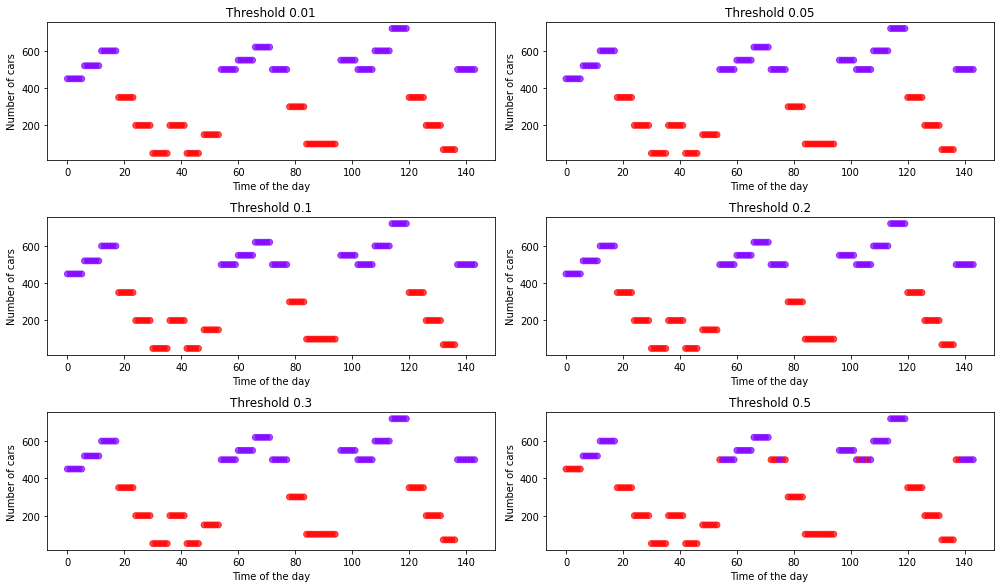

In [11]:
figure, axs = plt.subplots(nrows=3, ncols=2,figsize=(14,9))

axs[0,0].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_001, cmap='rainbow', alpha=0.7)
# axs[0,0].axvline(x=143, color='r')
axs[0,0].set_ylabel('Number of cars')
axs[0,0].set_xlabel('Time of the day')
axs[0,0].title.set_text("Threshold 0.01")

axs[0,1].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_005, cmap='rainbow', alpha=0.7)
# axs[0,0].axvline(x=143, color='r')
axs[0,1].set_ylabel('Number of cars')
axs[0,1].set_xlabel('Time of the day')
axs[0,1].title.set_text("Threshold 0.05")

axs[1,0].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_01, cmap='rainbow', alpha=0.7)    
# axs[0,1].axvline(x=143, color='r')
axs[1,0].set_ylabel('Number of cars')
axs[1,0].set_xlabel('Time of the day')
axs[1,0].title.set_text("Threshold 0.1")

axs[1,1].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_02, cmap='rainbow', alpha=0.7)   
# axs[1,0].axvline(x=143, color='r')
axs[1,1].set_ylabel('Number of cars')
axs[1,1].set_xlabel('Time of the day')
axs[1,1].title.set_text("Threshold 0.2")

axs[2,0].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_03, cmap='rainbow', alpha=0.7)
# axs[1,1].axvline(x=143, color='r')
axs[2,0].set_ylabel('Number of cars')
axs[2,0].set_xlabel('Time of the day')
axs[2,0].title.set_text("Threshold 0.3")

axs[2,1].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels, cmap='rainbow', alpha=0.7)
# axs[1,1].axvline(x=143, color='r')
axs[2,1].set_ylabel('Number of cars')
axs[2,1].set_xlabel('Time of the day')
axs[2,1].title.set_text("Threshold 0.5")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])
# figure.suptitle('Test of different Thresholds for BIRCH model', fontsize=20)

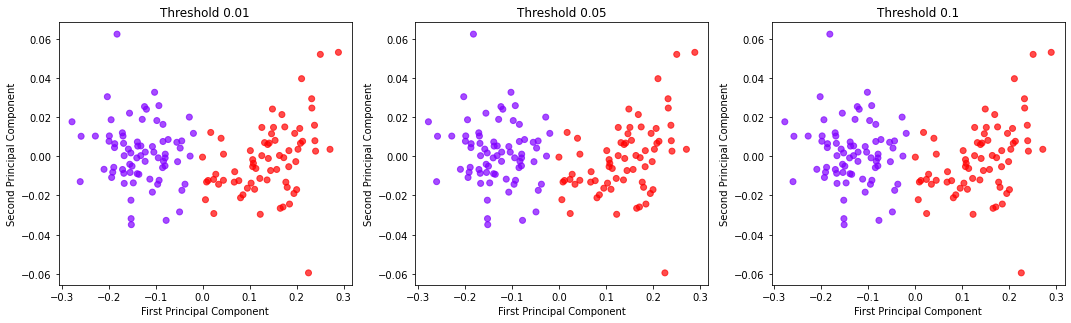

In [12]:
pca = PCA(n_components=2)
# pc_before = pca.fit_transform(df1[:, 3:])
pc_outliers = pca.fit_transform(data_split_modified_z_12[:, :2])

figure, axs = plt.subplots(nrows=1, ncols=
                           3,figsize=(15,5))

axs[0].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_001, cmap='rainbow', alpha=0.7)    
# axs[0,1].axvline(x=143, color='r')
axs[0].set_xlabel('First Principal Component')
axs[0].set_ylabel('Second Principal Component')
axs[0].title.set_text("Threshold 0.01")

axs[1].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_005, cmap='rainbow', alpha=0.7)    
# axs[0,1].axvline(x=143, color='r')
axs[1].set_xlabel('First Principal Component')
axs[1].set_ylabel('Second Principal Component')
axs[1].title.set_text("Threshold 0.05")

axs[2].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_01, cmap='rainbow', alpha=0.7)    
# axs[0,1].axvline(x=143, color='r')
axs[2].set_xlabel('First Principal Component')
axs[2].set_ylabel('Second Principal Component')
axs[2].title.set_text("Threshold 0.1")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])

In [29]:
df.shape

(288, 7)

In [30]:
data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
# data_split_modified_z = data_split_modified_z.iloc[:144, :]
data_split_modified_z = data_split_modified_z.to_numpy()

""" SIZE 12 """
data_split_modified_z_12 = np.split(data_split_modified_z, 16)
indexes = [] 

for d in range(len(data_split_modified_z_12)):
    ind = []
    k = len(data_split_modified_z_12[d])
    for i in [0, 1, 2, 3]:
        ys = data_split_modified_z_12[d][:,i] 
        median_y = np.median(ys)
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
#         print(median_absolute_deviation_y)
        for y in range(len(data_split_modified_z_12[d])):
            modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
#             z_score = (data_split[d][y, i]  - mean_ys) / std_ys
            if np.abs(modified_z_score) > 3.5:
                ind.append(y)


    data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)
#     print('Outliers detected: ' + str((k - len(data_split_modified_z_12[d]))))

data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)

In [31]:
data_split_modified_z_12.shape

(260, 6)

In [27]:
data_split_modified_z_12_list = np.split(data_split_modified_z_12, 5)

In [19]:
model_02 = Birch(n_clusters=None, threshold=0.2)

for i in data_split_modified_z_12_list:
    model_02.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)
print('threshold 0.2')
n = plot_silhouette_scores(model_02, data_split_modified_z_12[:, :-2], 2, 6)

model_02.set_params(n_clusters = n)
model_02.partial_fit()
    
labels_02 = model_02.predict(data_split_modified_z_12[:, :-2])
##########################################################
model_01= Birch(n_clusters=None, threshold=0.1)

for i in data_split_modified_z_12_list:
    model_01.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)
print('threshold 0.1')
n = plot_silhouette_scores(model_01, data_split_modified_z_12[:, :-2], 2, 6)

model_01.set_params(n_clusters = n)
model_01.partial_fit()
    
labels_01 = model_01.predict(data_split_modified_z_12[:, :-2])
##########################################################
model_03 = Birch(n_clusters=None, threshold=0.3)

for i in data_split_modified_z_12_list:
    model_03.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)
print('threshold 0.3')
n = plot_silhouette_scores(model_03, data_split_modified_z_12[:, :-2], 2, 6)

model_03.set_params(n_clusters = n)
model_03.partial_fit()
    
labels_03 = model_03.predict(data_split_modified_z_12[:, :-2])

##########################################################
model_005 = Birch(n_clusters=None, threshold=0.05)

for i in data_split_modified_z_12_list:
    model_005.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)
print('threshold 0.05')
n = plot_silhouette_scores(model_005, data_split_modified_z_12[:, :-2], 2, 6)

model_005.set_params(n_clusters = n)
model_005.partial_fit()
    
labels_005 = model_005.predict(data_split_modified_z_12[:, :-2])

##############################################################
model_001 = Birch(n_clusters=None, threshold=0.01)

for i in data_split_modified_z_12_list:
    model_001.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)
print('threshold 0.01')
n = plot_silhouette_scores(model_001, data_split_modified_z_12[:, :-2], 2, 6)

model_001.set_params(n_clusters = n)
model_001.partial_fit()
    
labels_001 = model_001.predict(data_split_modified_z_12[:, :-2])

##############################################################
model = Birch(n_clusters=None, threshold=0.5)

for i in data_split_modified_z_12_list:
    model.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)
print('threshold 0.5')
n = plot_silhouette_scores(model, data_split_modified_z_12[:, :-2], 2, 6)

model.set_params(n_clusters = n)
model.partial_fit()
    
labels = model.predict(data_split_modified_z_12[:, :-2])

threshold 0.2
[(2, 0.8974229602919177), (3, 0.8219113961944983), (4, 0.7705611909490425), (5, 0.7529117394649419), (6, 0.7427441844563456)]
The highest silhouette scores(0.8974229602919177) is for 2 clusers


threshold 0.1
[(2, 0.8974229602919177), (3, 0.8229682967645258), (4, 0.7788397015740341), (5, 0.7640844542646006), (6, 0.7616425017343215)]
The highest silhouette scores(0.8974229602919177) is for 2 clusers


threshold 0.3
[(2, 0.9027641318566845), (3, 0.7779416770010158), (4, 0.75378181194627), (5, 0.7605405121128161), (6, 0.7593942714566723)]
The highest silhouette scores(0.9027641318566845) is for 2 clusers


threshold 0.05
[(2, 0.8974229602919177), (3, 0.8229682967645258), (4, 0.7758105229288418), (5, 0.7594836379037254), (6, 0.7444771529940399)]
The highest silhouette scores(0.8974229602919177) is for 2 clusers


threshold 0.01
[(2, 0.8974229602919177), (3, 0.8229682967645258), (4, 0.7758105229288418), (5, 0.7594836379037254), (6, 0.5769099304090463)]
The highest silhouette s

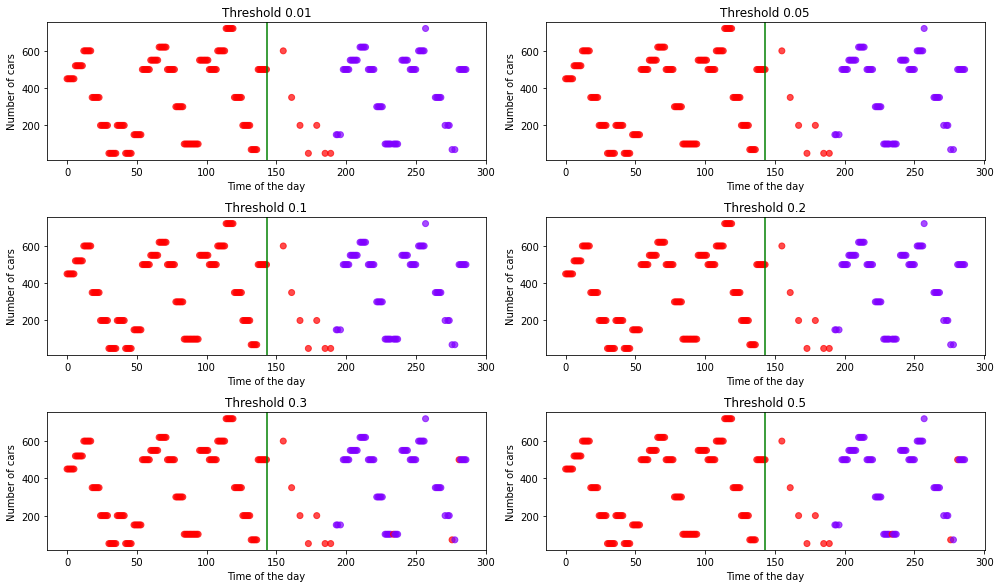

In [20]:
figure, axs = plt.subplots(nrows=3, ncols=2,figsize=(14,9))

axs[0,0].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_001, cmap='rainbow', alpha=0.7)
axs[0,0].axvline(x=143, color='g')
axs[0,0].set_ylabel('Number of cars')
axs[0,0].set_xlabel('Time of the day')
axs[0,0].title.set_text("Threshold 0.01")

axs[0,1].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_005, cmap='rainbow', alpha=0.7)
axs[0,1].axvline(x=143, color='g')
axs[0,1].set_ylabel('Number of cars')
axs[0,1].set_xlabel('Time of the day')
axs[0,1].title.set_text("Threshold 0.05")

axs[1,0].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_01, cmap='rainbow', alpha=0.7)    
axs[1,0].axvline(x=143, color='g')
axs[1,0].set_ylabel('Number of cars')
axs[1,0].set_xlabel('Time of the day')
axs[1,0].title.set_text("Threshold 0.1")

axs[1,1].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_02, cmap='rainbow', alpha=0.7)   
axs[1,1].axvline(x=143, color='g')
axs[1,1].set_ylabel('Number of cars')
axs[1,1].set_xlabel('Time of the day')
axs[1,1].title.set_text("Threshold 0.2")

axs[2,0].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_03, cmap='rainbow', alpha=0.7)
axs[2,0].axvline(x=143, color='g')
axs[2,0].set_ylabel('Number of cars')
axs[2,0].set_xlabel('Time of the day')
axs[2,0].title.set_text("Threshold 0.3")

axs[2,1].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels, cmap='rainbow', alpha=0.7)
axs[2,1].axvline(x=143, color='g')
axs[2,1].set_ylabel('Number of cars')
axs[2,1].set_xlabel('Time of the day')
axs[2,1].title.set_text("Threshold 0.5")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])
# figure.suptitle('Test of different Thresholds for BIRCH model', fontsize=20)

In [11]:

model_001_whole  = Birch(n_clusters=None, threshold=0.01)

for i in traindf_list:
    model_001_whole.partial_fit(i
                               )

# model.partial_fit(test_normal)
print('threshold 001')
n = plot_silhouette_scores(model_001_whole, data_to_plot[:, 3:], 2, 10)

model_001_whole.set_params(n_clusters = n)
model_001_whole.partial_fit()
    
labels_001_whole = model_001_whole.predict(data_to_plot[:, 3:])


##########################################################
model_005_whole = Birch(n_clusters=None, threshold=0.05)

for i in traindf_list:
    model_005_whole.partial_fit(i)

# model.partial_fit(test_normal)
print('threshold 005')
n = plot_silhouette_scores(model_005_whole, traindf, 2, 10)

model_005_whole.set_params(n_clusters = n)
model_005_whole.partial_fit()
    
labels_005_whole = model_005_whole.predict(data_to_plot[:, 3:])

model_01_whole = Birch(n_clusters=None, threshold=0.1)

for i in traindf_list:
    model_01_whole.partial_fit(i)

# model.partial_fit(test_normal)
print('threshold 01')
n = plot_silhouette_scores(model_01_whole, traindf, 2,10)

model_01_whole.set_params(n_clusters = n)
model_01_whole.partial_fit()
    
labels_01_whole = model_01_whole.predict(data_to_plot[:, 3:])


model_02_whole = Birch(n_clusters=None, threshold=0.2)

for i in traindf_list:
    model_02_whole.partial_fit(i)

# model.partial_fit(test_normal)
print('threshold 02')
n = plot_silhouette_scores(model_02_whole, traindf, 2,10)

model_02_whole.set_params(n_clusters = n)
model_02_whole.partial_fit()
    
labels_02_whole = model_02_whole.predict(data_to_plot[:, 3:])
##########################################################

##########################################################
model_03_whole = Birch(n_clusters=None, threshold=0.3)

for i in traindf_list:
    model_03_whole.partial_fit(i)

# model.partial_fit(test_normal)
print('threshold 03')
n = plot_silhouette_scores(model_03_whole, traindf, 2,10)

model_03_whole.set_params(n_clusters = n)
model_03_whole.partial_fit()
    
labels_03_whole = model_03_whole.predict(data_to_plot[:, 3:])


##############################################################

##############################################################
model_whole = Birch(n_clusters=None, threshold=0.5)

for i in traindf_list:
    model_whole.partial_fit(i)

# model.partial_fit(test_normal)
print('threshold 05')
n = plot_silhouette_scores(model_whole, data_to_plot[:, 3:], 2,10)

model_whole.set_params(n_clusters = n)
model_whole.partial_fit()
    
labels_whole = model_whole.predict(data_to_plot[:, 3:])

threshold 001
[(2, 0.8156353344393873), (3, 0.8245212383086978), (4, 0.8137910395391414), (5, 0.7130811693938863), (6, 0.7249558447103926), (7, 0.7400823558396681), (8, 0.7079940390559484), (9, 0.6930010553885882), (10, 0.6948636199524695)]
The highest silhouette scores(0.8245212383086978) is for 3 clusers


threshold 005
[(2, 0.8156353344393873), (3, 0.8245212383086978), (4, 0.8137910395391414), (5, 0.7130811693938863), (6, 0.7249558447103926), (7, 0.7400823558396681), (8, 0.7079940390559484), (9, 0.6930010553885882), (10, 0.6948636199524695)]
The highest silhouette scores(0.8245212383086978) is for 3 clusers


threshold 01
[(2, 0.8156353344393873), (3, 0.8245212383086978), (4, 0.8137910395391414), (5, 0.7130811693938863), (6, 0.7249558447103926), (7, 0.7400823558396681), (8, 0.7079940390559484), (9, 0.6930010553885882), (10, 0.6948636199524695)]
The highest silhouette scores(0.8245212383086978) is for 3 clusers


threshold 02
[(2, 0.8236081193912895), (3, 0.8325094335704368), (4, 0.8

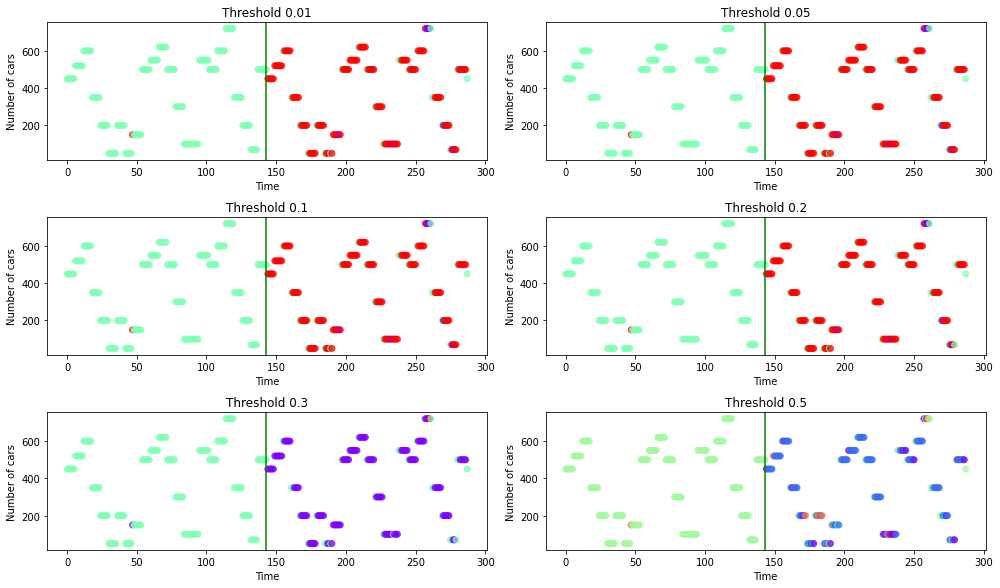

In [12]:
figure, axs = plt.subplots(nrows=3, ncols=2,figsize=(14,9))

axs[0,0].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_001_whole, cmap='rainbow', alpha=0.7)
axs[0,0].axvline(x=143, color='g')
axs[0,0].set_ylabel('Number of cars')
axs[0,0].set_xlabel('Time')
axs[0,0].title.set_text("Threshold 0.01")

axs[0,1].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_005_whole, cmap='rainbow', alpha=0.7)
axs[0,1].axvline(x=143, color='g')
axs[0,1].set_ylabel('Number of cars')
axs[0,1].set_xlabel('Time')
axs[0,1].title.set_text("Threshold 0.05")

axs[1,0].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_01_whole, cmap='rainbow', alpha=0.7)    
axs[1,0].axvline(x=143, color='g')
axs[1,0].set_ylabel('Number of cars')
axs[1,0].set_xlabel('Time')
axs[1,0].title.set_text("Threshold 0.1")

axs[1,1].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_02_whole, cmap='rainbow', alpha=0.7)   
axs[1,1].axvline(x=143, color='g')
axs[1,1].set_ylabel('Number of cars')
axs[1,1].set_xlabel('Time')
axs[1,1].title.set_text("Threshold 0.2")

axs[2,0].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_03_whole, cmap='rainbow', alpha=0.7)
axs[2,0].axvline(x=143, color='g')
axs[2,0].set_ylabel('Number of cars')
axs[2,0].set_xlabel('Time')
axs[2,0].title.set_text("Threshold 0.3")

axs[2,1].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_whole, cmap='rainbow', alpha=0.7)
axs[2,1].axvline(x=143, color='g')
axs[2,1].set_ylabel('Number of cars')
axs[2,1].set_xlabel('Time')
axs[2,1].title.set_text("Threshold 0.5")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])


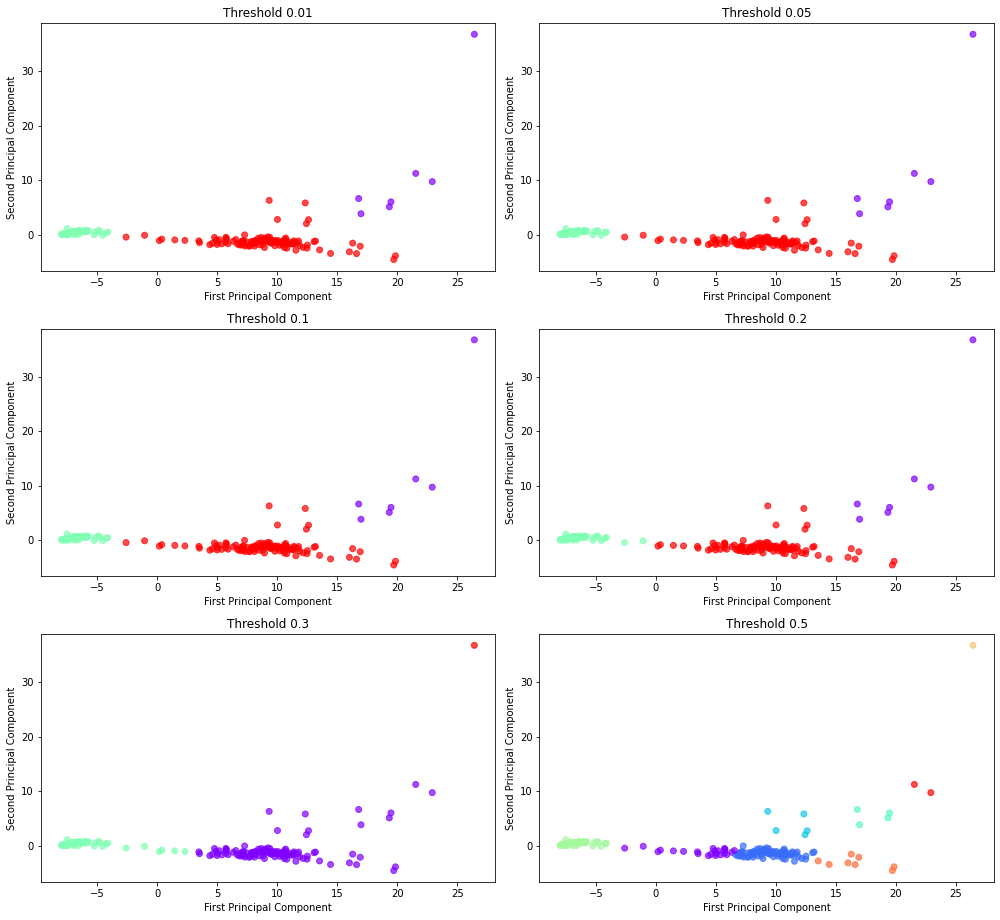

In [57]:
pca = PCA(n_components=2)
# pc_before = pca.fit_transform(df1[:, 3:])
pc_outliers = pca.fit_transform(data_to_plot[:, 3:])

figure, axs = plt.subplots(nrows=3, ncols=2,figsize=(14,14))

axs[0,0].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_001_whole, cmap='rainbow', alpha=0.7)
# axs[0,0].axvline(x=143, color='g')
axs[0,0].set_ylabel('Second Principal Component')
axs[0,0].set_xlabel('First Principal Component')
axs[0,0].title.set_text("Threshold 0.01")

axs[0,1].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_005_whole, cmap='rainbow', alpha=0.7)
# axs[0,1].axvline(x=143, color='g')
axs[0,1].set_ylabel('Second Principal Component')
axs[0,1].set_xlabel('First Principal Component')
axs[0,1].title.set_text("Threshold 0.05")

axs[1,0].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_01_whole, cmap='rainbow', alpha=0.7)    
# axs[1,0].axvline(x=143, color='g')
axs[1,0].set_ylabel('Second Principal Component')
axs[1,0].set_xlabel('First Principal Component')
axs[1,0].title.set_text("Threshold 0.1")

axs[1,1].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_02_whole, cmap='rainbow', alpha=0.7)   
# axs[1,1].axvline(x=143, color='g')
axs[1,1].set_ylabel('Second Principal Component')
axs[1,1].set_xlabel('First Principal Component')
axs[1,1].title.set_text("Threshold 0.2")

axs[2,0].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_03_whole, cmap='rainbow', alpha=0.7)
# axs[2,0].axvline(x=143, color='g')
axs[2,0].set_ylabel('Second Principal Component')
axs[2,0].set_xlabel('First Principal Component')
axs[2,0].title.set_text("Threshold 0.3")

axs[2,1].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_whole, cmap='rainbow', alpha=0.7)
# axs[2,1].axvline(x=143, color='g')
axs[2,1].set_ylabel('Second Principal Component')
axs[2,1].set_xlabel('First Principal Component')
axs[2,1].title.set_text("Threshold 0.5")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])

In [11]:
model_001_whole  = Birch(n_clusters=None, threshold=0.01)

for i in traindf_list:
    model_001_whole.partial_fit(i)

# model.partial_fit(test_normal)
# print('threshold 001')
# n = plot_silhouette_scores(model_001_whole, data_to_plot[:, 3:], 2, 10)

model_001_whole.set_params(n_clusters = 2)
model_001_whole.partial_fit()
    
labels_001_whole = model_001_whole.predict(data_to_plot[:, 3:])


##########################################################
model_005_whole = Birch(n_clusters=None, threshold=0.05)

for i in traindf_list:
    model_005_whole.partial_fit(i)

# model.partial_fit(test_normal)
# print('threshold 005')
# n = plot_silhouette_scores(model_005_whole, traindf, 2, 10)

model_005_whole.set_params(n_clusters = 2)
model_005_whole.partial_fit()
    
labels_005_whole = model_005_whole.predict(data_to_plot[:, 3:])

model_01_whole = Birch(n_clusters=None, threshold=0.1)

for i in traindf_list:
    model_01_whole.partial_fit(i)

# model.partial_fit(test_normal)
# print('threshold 01')
# n = plot_silhouette_scores(model_01_whole, traindf, 2,10)

model_01_whole.set_params(n_clusters =2)
model_01_whole.partial_fit()
    
labels_01_whole = model_01_whole.predict(data_to_plot[:, 3:])


model_02_whole = Birch(n_clusters=None, threshold=0.2)

for i in traindf_list:
    model_02_whole.partial_fit(i)

# model.partial_fit(test_normal)
# print('threshold 02')
# n = plot_silhouette_scores(model_02_whole, traindf, 2,10)

model_02_whole.set_params(n_clusters = 2)
model_02_whole.partial_fit()
    
labels_02_whole = model_02_whole.predict(data_to_plot[:, 3:])
##########################################################

##########################################################
model_03_whole = Birch(n_clusters=None, threshold=0.3)

for i in traindf_list:
    model_03_whole.partial_fit(i)

# model.partial_fit(test_normal)
# print('threshold 03')
# n = plot_silhouette_scores(model_03_whole, traindf, 2,10)

model_03_whole.set_params(n_clusters = 2)
model_03_whole.partial_fit()
    
labels_03_whole = model_03_whole.predict(data_to_plot[:, 3:])


##############################################################

##############################################################
model_whole = Birch(n_clusters=None, threshold=0.5)

for i in traindf_list:
    model_whole.partial_fit(i)

# model.partial_fit(test_normal)
# print('threshold 05')
# n = plot_silhouette_scores(model_whole, data_to_plot[:, 3:], 2,10)

model_whole.set_params(n_clusters = 2)
model_whole.partial_fit()
    
labels_whole = model_whole.predict(data_to_plot[:, 3:])

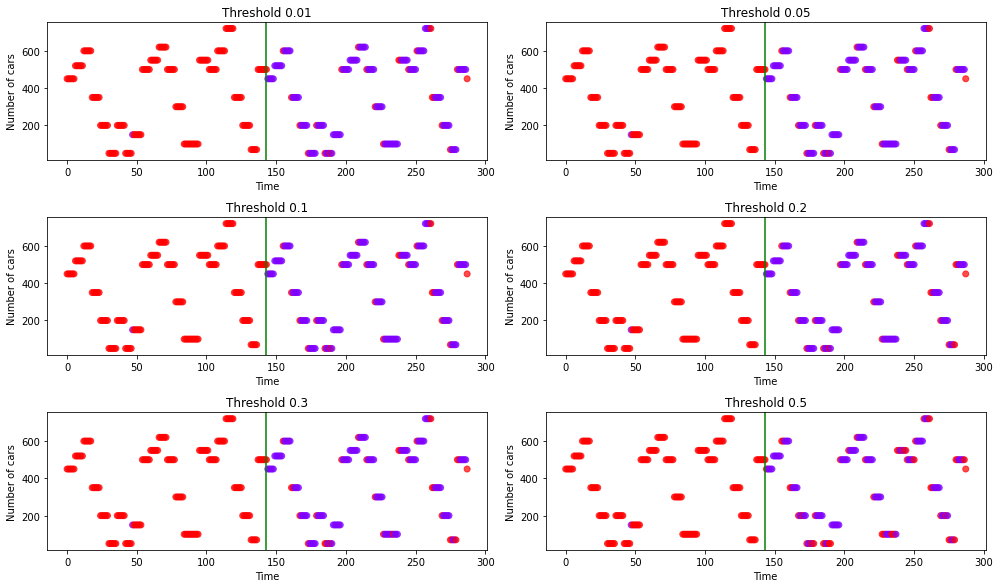

In [12]:
figure, axs = plt.subplots(nrows=3, ncols=2,figsize=(14,9))

axs[0,0].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_001_whole, cmap='rainbow', alpha=0.7)
axs[0,0].axvline(x=143, color='g')
axs[0,0].set_ylabel('Number of cars')
axs[0,0].set_xlabel('Time')
axs[0,0].title.set_text("Threshold 0.01")

axs[0,1].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_005_whole, cmap='rainbow', alpha=0.7)
axs[0,1].axvline(x=143, color='g')
axs[0,1].set_ylabel('Number of cars')
axs[0,1].set_xlabel('Time')
axs[0,1].title.set_text("Threshold 0.05")

axs[1,0].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_01_whole, cmap='rainbow', alpha=0.7)    
axs[1,0].axvline(x=143, color='g')
axs[1,0].set_ylabel('Number of cars')
axs[1,0].set_xlabel('Time')
axs[1,0].title.set_text("Threshold 0.1")

axs[1,1].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_02_whole, cmap='rainbow', alpha=0.7)   
axs[1,1].axvline(x=143, color='g')
axs[1,1].set_ylabel('Number of cars')
axs[1,1].set_xlabel('Time')
axs[1,1].title.set_text("Threshold 0.2")

axs[2,0].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_03_whole, cmap='rainbow', alpha=0.7)
axs[2,0].axvline(x=143, color='g')
axs[2,0].set_ylabel('Number of cars')
axs[2,0].set_xlabel('Time')
axs[2,0].title.set_text("Threshold 0.3")

axs[2,1].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_whole, cmap='rainbow', alpha=0.7)
axs[2,1].axvline(x=143, color='g')
axs[2,1].set_ylabel('Number of cars')
axs[2,1].set_xlabel('Time')
axs[2,1].title.set_text("Threshold 0.5")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])

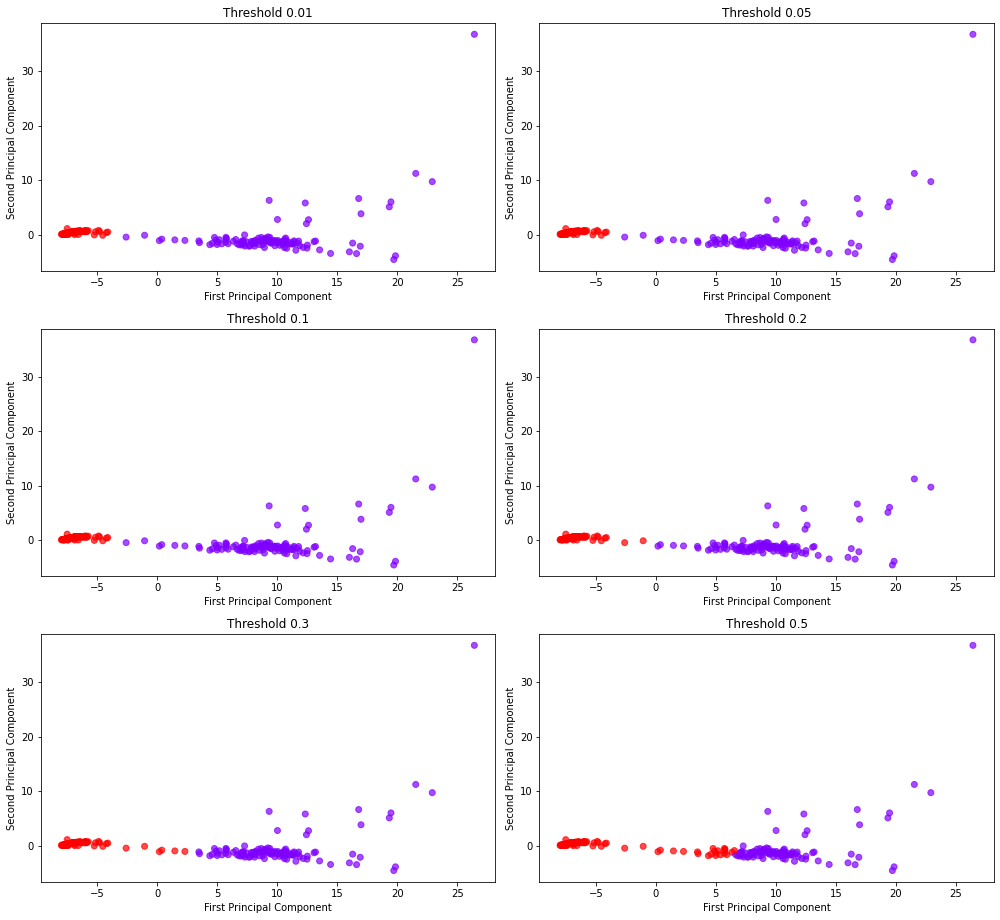

In [61]:
pca = PCA(n_components=2)
# pc_before = pca.fit_transform(df1[:, 3:])
pc_outliers = pca.fit_transform(data_to_plot[:, 3:])

figure, axs = plt.subplots(nrows=3, ncols=2,figsize=(14,14))

axs[0,0].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_001_whole, cmap='rainbow', alpha=0.7)
# axs[0,0].axvline(x=143, color='g')
axs[0,0].set_ylabel('Second Principal Component')
axs[0,0].set_xlabel('First Principal Component')
axs[0,0].title.set_text("Threshold 0.01")

axs[0,1].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_005_whole, cmap='rainbow', alpha=0.7)
# axs[0,1].axvline(x=143, color='g')
axs[0,1].set_ylabel('Second Principal Component')
axs[0,1].set_xlabel('First Principal Component')
axs[0,1].title.set_text("Threshold 0.05")

axs[1,0].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_01_whole, cmap='rainbow', alpha=0.7)    
# axs[1,0].axvline(x=143, color='g')
axs[1,0].set_ylabel('Second Principal Component')
axs[1,0].set_xlabel('First Principal Component')
axs[1,0].title.set_text("Threshold 0.1")

axs[1,1].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_02_whole, cmap='rainbow', alpha=0.7)   
# axs[1,1].axvline(x=143, color='g')
axs[1,1].set_ylabel('Second Principal Component')
axs[1,1].set_xlabel('First Principal Component')
axs[1,1].title.set_text("Threshold 0.2")

axs[2,0].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_03_whole, cmap='rainbow', alpha=0.7)
# axs[2,0].axvline(x=143, color='g')
axs[2,0].set_ylabel('Second Principal Component')
axs[2,0].set_xlabel('First Principal Component')
axs[2,0].title.set_text("Threshold 0.3")

axs[2,1].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_whole, cmap='rainbow', alpha=0.7)
# axs[2,1].axvline(x=143, color='g')
axs[2,1].set_ylabel('Second Principal Component')
axs[2,1].set_xlabel('First Principal Component')
axs[2,1].title.set_text("Threshold 0.5")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])

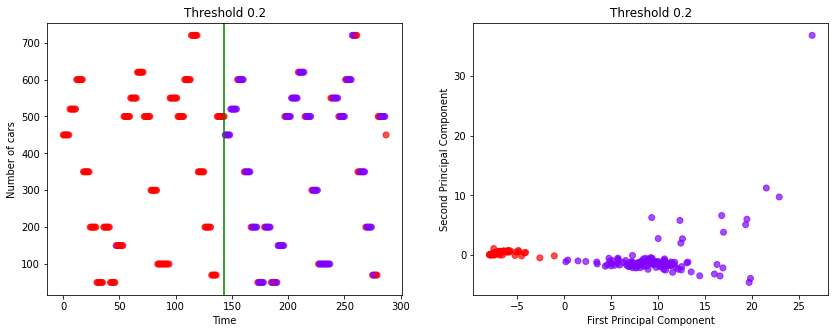

In [63]:
figure, axs = plt.subplots(nrows=1, ncols=2,figsize=(14,5))

axs[0].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_02_whole, cmap='rainbow', alpha=0.7)   
axs[0].axvline(x=143, color='g')
axs[0].set_ylabel('Number of cars')
axs[0].set_xlabel('Time')
axs[0].title.set_text("Threshold 0.2")



axs[1].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_02_whole, cmap='rainbow', alpha=0.7)   
# axs[1,1].axvline(x=143, color='g')
axs[1].set_ylabel('Second Principal Component')
axs[1].set_xlabel('First Principal Component')
axs[1].title.set_text("Threshold 0.2")